# Content Based Recommender System

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

# Read the data

In [2]:
df = pd.read_csv("anime.csv")
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [3]:
df.shape

(12294, 7)

In [4]:
df.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

# Handling Missing Value

## Handling missing rating

In [5]:
df.loc[df['rating'].isnull(), 'rating'] = 0.0
df['rating'].isnull().any()

False

## Handling missing type

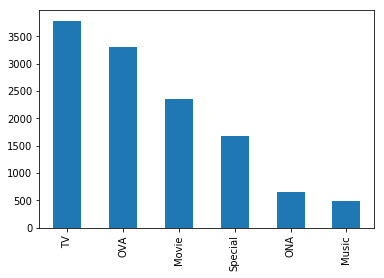

In [6]:
df['type'].value_counts().plot.bar()

My approach is to fill the missing type based on the number of the episodes. But after checking the data, some of the anime have 'unknown' episodes and missing type.

In [7]:
df.loc[(df['episodes']=="Unknown") & (df['type'].isnull())].head()

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,0.0,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,0.0,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,0.0,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,0.0,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,0.0,8666


In [8]:
missing = df.loc[(df['episodes']=="Unknown") & (df['type'].isnull())].copy()
missing.shape

(25, 7)

Oh man, this data is not up to date with the current season. We have to manually fill the type and the episodes.

In [9]:
missing.head(25)

,anime_id,name,genre,type,episodes,rating,members
10898,30484,Steins;Gate 0,"Sci-Fi, Thriller",NaN,Unknown,0.0,60999
10900,34437,Code Geass: Fukkatsu no Lelouch,"Action, Drama, Mecha, Military, Sci-Fi, Super ...",NaN,Unknown,0.0,22748
10906,33352,Violet Evergarden,"Drama, Fantasy",NaN,Unknown,0.0,20564
10907,33248,K: Seven Stories,"Action, Drama, Super Power, Supernatural",NaN,Unknown,0.0,22133
10918,33845,Free! (Shinsaku),"School, Sports",NaN,Unknown,0.0,8666
10949,33475,Busou Shoujo Machiavellianism,"Action, School, Shounen",NaN,Unknown,0.0,1896
10963,31456,Code:Realize: Sousei no Himegimi,"Adventure, Fantasy, Romance, Shoujo",NaN,Unknown,0.0,4017
10983,34332,Flying Babies,NaN,NaN,Unknown,0.0,22
10988,34280,Gamers!,"Comedy, Romance, School",NaN,Unknown,0.0,1045
10990,34485,Ganko-chan,NaN,NaN,Unknown,0.0,11


In [10]:
df.loc[(df['name'] == "Steins;Gate 0"), 'type'] = 'TV'
df.loc[(df['name'] == "Steins;Gate 0"), 'episodes'] = '23'
df.loc[(df['name'] == "Violet Evergarden"), 'type'] = 'TV'
df.loc[(df['name'] == "Violet Evergarden"), 'episodes'] = '13'
df.loc[(df['name'] == "Code Geass: Fukkatsu no Lelouch"), 'type'] = 'TV'
df.loc[(df['name'] == "Code Geass: Fukkatsu no Lelouch"), 'episodes'] = '25'
df.loc[(df['name'] == "K: Seven Stories"), 'type'] = 'Movie'
df.loc[(df['name'] == "K: Seven Stories"), 'episodes'] = '6'
df.loc[(df['name'] == "Free! (Shinsaku)"), 'type'] = 'TV'
df.loc[(df['name'] == "Free! (Shinsaku)"), 'episodes'] = '12'
df.loc[(df['name'] == "Busou Shoujo Machiavellianism"), 'type'] = 'TV'
df.loc[(df['name'] == "Busou Shoujo Machiavellianism"), 'episodes'] = '12'
df.loc[(df['name'] == "Code:Realize: Sousei no Himegimi"), 'type'] = 'TV'
df.loc[(df['name'] == "Code:Realize: Sousei no Himegimi"), 'episodes'] = '12'
df.loc[(df['name'] == "Gamers!"), 'type'] = 'TV'
df.loc[(df['name'] == "Gamers!"), 'episodes'] = '12'
df.loc[(df['name'] == "Ganko-chan"), 'type'] = 'TV'
df.loc[(df['name'] == "Ganko-chan"), 'episodes'] = '10'
df.loc[(df['name'] == "Ginga Eiyuu Densetsu (2017)"), 'type'] = 'OVA'
df.loc[(df['name'] == "Ginga Eiyuu Densetsu (2017)"), 'episodes'] = '110'
df.loc[(df['name'] == "Grancrest Senki"), 'type'] = 'TV'
df.loc[(df['name'] == "Grancrest Senki"), 'episodes'] = '24'
df.loc[(df['name'] == "IDOLiSH7"), 'type'] = 'TV'
df.loc[(df['name'] == "IDOLiSH7"), 'episodes'] = '17'
df.loc[(df['name'] == "Isekai Shokudou"), 'type'] = 'TV'
df.loc[(df['name'] == "Isekai Shokudou"), 'episodes'] = '12'
df.loc[(df['name'] == "Oushitsu Kyoushi Haine"), 'type'] = 'TV'
df.loc[(df['name'] == "Oushitsu Kyoushi Haine"), 'episodes'] = '12'
df.loc[(df['name'] == "Peace Maker Kurogane (Shinsaku)"), 'type'] = 'TV'
df.loc[(df['name'] == "Peace Maker Kurogane (Shinsaku)"), 'episodes'] = '24'
df.loc[(df['name'] == "Seikaisuru Kado"), 'type'] = 'TV'
df.loc[(df['name'] == "Seikaisuru Kado"), 'episodes'] = '12'
df.loc[(df['name'] == "UQ Holder!"), 'type'] = 'TV'
df.loc[(df['name'] == "UQ Holder!"), 'episodes'] = '12'
df.loc[(df['name'] == "Citrus"), 'type'] = 'TV'
df.loc[(df['name'] == "Citrus"), 'episodes'] = '12'
df.loc[(df['name'] == "Hitorijime My Hero"), 'type'] = 'TV'
df.loc[(df['name'] == "Hitorijime My Hero"), 'episodes'] = '12'
df.isnull().sum()

anime_id     0
name         0
genre       62
type         6
episodes     0
rating       0
members      0
dtype: int64

There still some unknown 'type', because it has not yet aired. I will drop those anime.

In [11]:
df.dropna(subset=['type'], inplace=True)
df.shape

(12288, 7)

## Handling unknown episodes

There are still many unknown episodes, this is because some anime are still airing. My approach is to fill the episodes based on the type

In [12]:
df.episodes[df['episodes'] == "Unknown"].value_counts()

Unknown    315
Name: episodes, dtype: int64

First, let's replace the 'Unknown' with zero values

In [13]:
df['episodes'].replace('Unknown', '0', inplace=True)

In [14]:
df['episodes'] = df['episodes'].astype(int)

In [15]:
df[df['episodes']>0].groupby('type')['episodes'].median()

type
Movie       1
Music       1
ONA         2
OVA         2
Special     1
TV         24
Name: episodes, dtype: int64

In [16]:
df.loc[(df['episodes'] == 0) & (df['type'] == "Movie"), 'episodes'] = 1
df.loc[(df['episodes'] == 0) & (df['type'] == "Music"), 'episodes'] = 1
df.loc[(df['episodes'] == 0) & (df['type'] == "ONA"), 'episodes'] = 2
df.loc[(df['episodes'] == 0) & (df['type'] == "OVA"), 'episodes'] = 2
df.loc[(df['episodes'] == 0) & (df['type'] == "Special"), 'episodes'] = 1
df.loc[(df['episodes'] == 0) & (df['type'] == "TV"), 'episodes'] = 24

In [17]:
df[df['episodes'] == 0].any()

anime_id    False
name        False
genre       False
type        False
episodes    False
rating      False
members     False
dtype: bool

I know that some anime like One Piece, Conan, etc are still airing. But for the sake of this analysis, we just fill their number of episodes with the median value.

## Handling Unknown Genre

In [18]:
df.isnull().sum()

anime_id     0
name         0
genre       61
type         0
episodes     0
rating       0
members      0
dtype: int64

In [19]:
df[df['genre'].isnull()].head()

,anime_id,name,genre,type,episodes,rating,members
2844,33242,IS: Infinite Stratos 2 - Infinite Wedding,NaN,Special,1,7.15,6604
3541,33589,ViVid Strike!,NaN,TV,12,6.96,12345
6040,29765,Metropolis (2009),NaN,Movie,1,6.27,313
6646,32695,Match Shoujo,NaN,ONA,1,6.02,242
7018,33187,Katsudou Shashin,NaN,Movie,1,5.79,607


For now, let's just fill it with 'Unknown'.

In [20]:
df['genre'].fillna('Unknown', inplace=True)
df.isnull().any()

anime_id    False
name        False
genre       False
type        False
episodes    False
rating      False
members     False
dtype: bool

<br>
# Build the Recommender System

In [21]:
df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


## Calculate Weighted Rating

In [22]:
m = df.members.quantile(0.75)
C = df.rating.mean()
print(m, C)

9448.5 6.355887858072929


In [23]:
def weighted_rating(df, m, C):
    term = df['members'] / (m + df['members'])
    return df['rating'] * term + (1-term) * C

In [24]:
df['community_rating'] = df.apply(weighted_rating, axis=1, args=(m,C))
df.head()

,anime_id,name,genre,type,episodes,rating,members,community_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,9.234437
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,9.225834
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,9.028960
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,9.131071
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,8.995145


## Convert to Categorical

In [25]:
# type
df['type'] = df['type'].map({
    "Movie":0,
    "Music":1,
    "OVA": 2,
    "ONA": 3,
    "Special":4,
    "TV": 5
})
df.head()

,anime_id,name,genre,type,episodes,rating,members,community_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",0,1,9.37,200630,9.234437
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",5,64,9.26,793665,9.225834
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",5,51,9.25,114262,9.028960
3,9253,Steins;Gate,"Sci-Fi, Thriller",5,24,9.17,673572,9.131071
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",5,51,9.16,151266,8.995145


In [26]:
# episodes
df.loc[(df['episodes'] < 10), 'episodes'] = 0
df.loc[(df['episodes'] >= 10) & (df['episodes'] < 20), 'episodes'] = 1
df.loc[(df['episodes'] >= 20) & (df['episodes'] < 40), 'episodes'] = 2
df.loc[(df['episodes'] >= 40), 'episodes'] = 3
df.head()

,anime_id,name,genre,type,episodes,rating,members,community_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",0,0,9.37,200630,9.234437
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",5,3,9.26,793665,9.225834
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",5,3,9.25,114262,9.028960
3,9253,Steins;Gate,"Sci-Fi, Thriller",5,2,9.17,673572,9.131071
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",5,3,9.16,151266,8.995145


In [27]:
# community_rating
df.loc[(df['community_rating'] == 0), 'community_rating'] = 0
df.loc[(df['community_rating'] > 0) & (df['community_rating'] < 5), 'community_rating'] = 1
df.loc[(df['community_rating'] >= 5) & (df['community_rating'] < 6.25), 'community_rating'] = 2
df.loc[(df['community_rating'] >= 6.25) & (df['community_rating'] < 7.5), 'community_rating'] = 3
df.loc[(df['community_rating'] >= 7.5) & (df['community_rating'] < 8.75), 'community_rating'] = 4
df.loc[(df['community_rating'] >= 8.75), 'community_rating'] = 5
df.head()

,anime_id,name,genre,type,episodes,rating,members,community_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",0,0,9.37,200630,5.0
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",5,3,9.26,793665,5.0
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",5,3,9.25,114262,5.0
3,9253,Steins;Gate,"Sci-Fi, Thriller",5,2,9.17,673572,5.0
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",5,3,9.16,151266,5.0


## Dropping some unused columns

In [28]:
df.drop(['anime_id', 'rating', 'members'], axis=1, inplace=True)
df.head()

,name,genre,type,episodes,community_rating
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",0,0,5.0
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",5,3,5.0
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",5,3,5.0
3,Steins;Gate,"Sci-Fi, Thriller",5,2,5.0
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",5,3,5.0


## Breakdown the genre

In [29]:
df = pd.concat([df, df['genre'].str.get_dummies(sep=',')], axis=1)
df.head()

,name,genre,type,episodes,community_rating,Adventure,Cars,Comedy,Dementia,Demons,...,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",0,0,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",5,3,5.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",5,3,5.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Steins;Gate,"Sci-Fi, Thriller",5,2,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",5,3,5.0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
anime_features = df.loc[:, "type":].copy()
anime_features.head()

,type,episodes,community_rating,Adventure,Cars,Comedy,Dementia,Demons,Drama,Ecchi,...,Shounen,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Unknown,Vampire,Yaoi
0,0,0,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,3,5.0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,5,3,5.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,5,2,5.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,3,5.0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Calculate the similarity matrix

In [31]:
cosine_sim = cosine_similarity(anime_features.values, anime_features.values)

In [32]:
cosine_sim

array([[ 1.        ,  0.5714379 ,  0.5714379 , ...,  0.7444375 ,
         0.7444375 ,  0.88083033],
       [ 0.5714379 ,  1.        ,  0.92424242, ...,  0.82243962,
         0.82243962,  0.58387421],
       [ 0.5714379 ,  0.92424242,  1.        , ...,  0.82243962,
         0.82243962,  0.58387421],
       ..., 
       [ 0.7444375 ,  0.82243962,  0.82243962, ...,  1.        ,
         1.        ,  0.84515425],
       [ 0.7444375 ,  0.82243962,  0.82243962, ...,  1.        ,
         1.        ,  0.84515425],
       [ 0.88083033,  0.58387421,  0.58387421, ...,  0.84515425,
         0.84515425,  1.        ]])

Now we must create an indexing for each anime name, this will be used when user querying a recommendation.

In [33]:
anime_index = pd.Series(df.index, index=df.name).drop_duplicates()

In [34]:
def get_recommendation(anime_name, similarity=cosine_sim):
    idx = anime_index[anime_name]
    
    # Get the pairwsie similarity scores of all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar anime
    sim_scores = sim_scores[0:11]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar anime
    result = df[['name', 'genre', 'community_rating']].iloc[anime_indices].drop(idx)
    return result

In [35]:
get_recommendation("Steins;Gate")

,name,genre,community_rating
9674,Nanocore,Sci-Fi,3.0
10262,Shitamachi Alien PapiPipiPupi,Sci-Fi,3.0
250,Zankyou no Terror,"Psychological, Thriller",4.0
10079,RoboDz,Sci-Fi,3.0
10858,Yuusei Kamen,Sci-Fi,3.0
126,Steins;Gate: Oukoubakko no Poriomania,"Sci-Fi, Thriller",4.0
196,Steins;Gate: Kyoukaimenjou no Missing Link - D...,"Sci-Fi, Thriller",4.0
321,Tokyo Magnitude 8.0,Drama,4.0
1062,Kamisama no Memochou,Mystery,4.0
3581,Fireball Charming,Sci-Fi,3.0


In [36]:
get_recommendation("Kimi no Na wa.")

,name,genre,community_rating
208,Kokoro ga Sakebitagatterunda.,"Drama, Romance, School",4.0
1494,Harmonie,"Drama, School, Supernatural",3.0
1959,Air Movie,"Drama, Romance, Supernatural",3.0
60,Hotarubi no Mori e,"Drama, Romance, Shoujo, Supernatural",4.0
894,Momo e no Tegami,"Drama, Supernatural",3.0
5697,Shiranpuri (Movie),"Drama, School",3.0
6119,Shisha no Sho,"Drama, Supernatural",3.0
10123,Samurai,"Drama, Romance",3.0
11,Koe no Katachi,"Drama, School, Shounen",5.0
244,Tsumiki no Ie,Drama,4.0


In [37]:
get_recommendation("Kokoro ga Sakebitagatterunda.")

,name,genre,community_rating
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural",5.0
5697,Shiranpuri (Movie),"Drama, School",3.0
10123,Samurai,"Drama, Romance",3.0
1199,&quot;Bungaku Shoujo&quot; Movie,"Drama, Mystery, Romance, School",3.0
2103,Clannad Movie,"Drama, Fantasy, Romance, School",3.0
11,Koe no Katachi,"Drama, School, Shounen",5.0
265,Kaze Tachinu,"Drama, Historical, Romance",4.0
411,Byousoku 5 Centimeter,"Drama, Romance, Slice of Life",4.0
244,Tsumiki no Ie,Drama,4.0
1850,Black Jack: Futari no Kuroi Isha,Drama,3.0


In [38]:
get_recommendation("Naruto")

,name,genre,community_rating
615,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P...",4.0
175,Katekyo Hitman Reborn!,"Action, Comedy, Shounen, Super Power",4.0
206,Dragon Ball Z,"Action, Adventure, Comedy, Fantasy, Martial Ar...",4.0
515,Dragon Ball Kai (2014),"Action, Adventure, Comedy, Fantasy, Martial Ar...",4.0
588,Dragon Ball Kai,"Action, Adventure, Comedy, Fantasy, Martial Ar...",4.0
260,Shijou Saikyou no Deshi Kenichi,"Action, Comedy, Martial Arts, School, Shounen",4.0
582,Bleach,"Action, Comedy, Shounen, Super Power, Supernat...",4.0
1796,Rekka no Honoo,"Action, Adventure, Martial Arts, Shounen, Supe...",3.0
2913,Kenyuu Densetsu Yaiba,"Action, Comedy, Fantasy, Martial Arts, Shounen",3.0
346,Dragon Ball,"Adventure, Comedy, Fantasy, Martial Arts, Shou...",4.0


In [39]:
get_recommendation("Noragami")

,name,genre,community_rating
113,Noragami Aragoto,"Action, Adventure, Shounen, Supernatural",4.0
3120,Yumekui Merry,"Action, Shounen, Supernatural",3.0
64,JoJo no Kimyou na Bouken: Stardust Crusaders 2...,"Action, Adventure, Drama, Shounen, Supernatural",4.0
95,JoJo no Kimyou na Bouken (TV),"Action, Adventure, Shounen, Supernatural, Vampire",4.0
257,JoJo no Kimyou na Bouken: Stardust Crusaders,"Action, Adventure, Drama, Shounen, Supernatural",4.0
2694,Zombie-Loan Specials,"Action, Shounen, Supernatural",3.0
76,JoJo no Kimyou na Bouken: Diamond wa Kudakenai,"Action, Adventure, Comedy, Drama, Shounen, Sup...",4.0
141,Nanatsu no Taizai,"Action, Adventure, Ecchi, Fantasy, Shounen, Su...",4.0
1049,Ushio to Tora (TV),"Action, Adventure, Comedy, Demons, Shounen, Su...",4.0
3985,Nobunagun,"Action, Supernatural",3.0


In [40]:
get_recommendation("Plastic Memories")

,name,genre,community_rating
4084,Ray The Animation,"Drama, Romance, Sci-Fi",3.0
6366,Seraphim Call,"Drama, Romance, Sci-Fi",3.0
1122,Kiznaiver,"Drama, Sci-Fi",4.0
5568,Sister Princess: Re Pure Character&#039;s,"Drama, Romance",3.0
5731,Sister Princess: Re Pure,"Drama, Romance",3.0
2279,Saishuu Heiki Kanojo,"Drama, Romance, School, Sci-Fi",3.0
4002,Ushinawareta Mirai wo Motomete,"Drama, Romance, School, Sci-Fi",3.0
897,Orange,"Drama, Romance, School, Sci-Fi, Shoujo",4.0
172,Hachimitsu to Clover II,"Drama, Josei, Romance",4.0
392,ef: A Tale of Memories.,"Drama, Mystery, Romance",4.0
